# Clustering de documents

## Imports

In [14]:
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [15]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
data_path = "../data/txt/"

## Choisir une décennie

In [17]:
year = '1874'

## Charger tous les  fichiers de la décennie et en créer une liste de textes

In [18]:
files = [f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f)) and str(year) in f and "RptAn" in f]

In [19]:
# Exemple de fichiers
files[:5]

['Lkn_1874_Tome_RptAn_Part_8.txt']

In [20]:
texts = [open(data_path + f).read() for f in files]

In [21]:
# Exemple de textes
texts[0][:400]

"— 406 —\ndevaient être déposées, et nous leur avons demandé si une heure\nleur suffisait pour modifier leur soumission, à quoi ils ont tous\nrépondu qu'ils avaient leurs apaisements. Nous leur offrions , dans\nle cas contraire, de remettre l'adjudication au lendemain.\nInterpellés par moi sur le poinldesavoir s'ils connaissaient bien leurs\nobligations, les entrepreneurs m'ont tous répondu affirmativeme"

## Vectoriser les documents à l'aide de TF-IDF

In [22]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

### Instancier le modèle TF-IDF avec ses arguments

In [23]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

### Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

In [24]:
%time tfidf_vectors = vectorizer.fit_transform(texts)

ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

In [13]:
# Détail de la matrice
tfidf_vectors

NameError: name 'tfidf_vectors' is not defined

### Imprimer le vecteur tf-IDF du premier document

In [ ]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

## Comprendre les vecteurs et leurs "distances"

In [19]:
cosine([1, 2, 3], [1, 2, 3])

0

In [20]:
cosine([1, 2, 3], [1, 2, 2])

0.02004211298777725

In [21]:
cosine([1, 2, 3], [2, 2, 2])

0.07417990022744858

### Tests sur nos documents

In [22]:
tfidf_array = tfidf_vectors.toarray()

In [23]:
# Vecteur du document 0
tfidf_array[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [24]:
# Vecteur du document 1
tfidf_array[1]

array([0.        , 0.        , 0.00848307, ..., 0.01090603, 0.        ,
       0.        ])

In [25]:
cosine(tfidf_array[0], tfidf_array[1])

0.976278841824659

## Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

Pour en savoir plus sur le KMeans clustering :
- https://medium.com/dataseries/k-means-clustering-explained-visually-in-5-minutes-b900cc69d175

### Définir un nombre de clusters

In [51]:
N_CLUSTERS = 4

### Instancier le modèle K-Means et ses arguments

In [52]:
km_model = KMeans(n_clusters=N_CLUSTERS)

### Appliquer le clustering à l'aide de la fonction `fit_predict`

In [53]:
clusters = km_model.fit_predict(tfidf_vectors)

In [54]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [55]:
pprint(dict(clustering))

{0: ['Lkn_1874_Tome_RptAn_Part_8.txt',
     'Lkn_1874_Tome_RptAn_Part_7.txt',
     'Lkn_1874_Tome_RptAn_Part_6.txt',
     'Lkn_1874_Tome_RptAn_Part_1.txt',
     'Lkn_1874_Tome_RptAn_Part_9.txt'],
 1: ['Lkn_1874_Tome_RptAn_Part_10.txt'],
 2: ['Lkn_1874_Tome_RptAn_Part_4.txt'],
 3: ['Lkn_1874_Tome_RptAn_Part_3.txt',
     'Lkn_1874_Tome_RptAn_Part_2.txt',
     'Lkn_1874_Tome_RptAn_Part_5.txt']}


## Visualiser les clusters

### Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA
Cette étape est nécessaire afin de visualiser les documents dans un espace 2D

https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales

In [56]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [57]:
reduced_vectors[:10]

array([[-0.03726004,  0.51946765],
       [ 0.78404226, -0.36153678],
       [ 0.01335906,  0.2628706 ],
       [-0.34146816, -0.37771126],
       [-0.39597172, -0.40381781],
       [ 0.2897609 , -0.09463864],
       [-0.19900583, -0.09584643],
       [-0.08009579,  0.22823774],
       [-0.10997   , -0.0659964 ],
       [ 0.07660932,  0.38897133]])

### Générer le plot

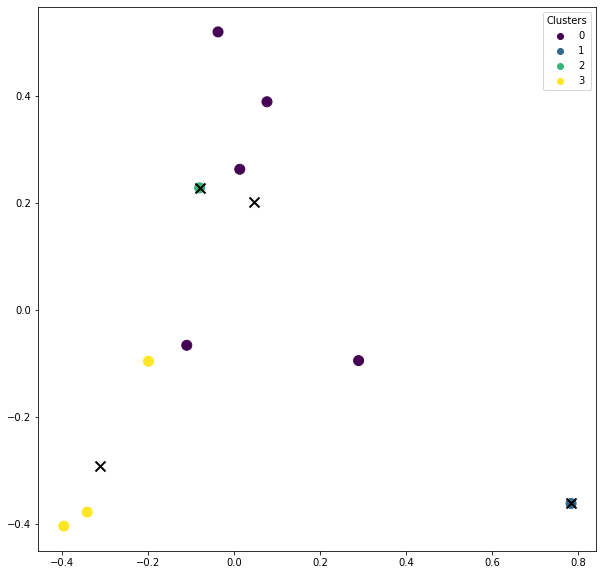

In [58]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")